<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson05_VAE_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 5. Simple VAE excerise
1. Re-use lesson 3's code
2. Try to implement your simple VAE using the MNIST dataset
3. Explore some simple ideas about the generative model
4. Compare the results with Pytorch


In [22]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transform

In [23]:
tt = transform.Compose([transform.ToTensor()])

train_data = MNIST(root='./data', train=True, transform=tt, download=True)
test_data = MNIST(root='./data', train=False, transform=tt)

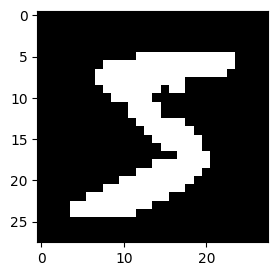

In [28]:
def transform_from_torch_to_numpy(torch_data):
    features_np = torch_data.data.numpy()
    labels_np = torch_data.targets.numpy()

    features_np = np.resize(features_np, (features_np.shape[0], features_np.shape[1] * features_np.shape[2]))

    # Simplify the exercise
    features_np[features_np != 0] = 1

    labels = np.zeros((labels_np.shape[0], 10))
    for i in range(10):
        labels[labels_np==i, i] = 1.

    return features_np, labels

train_features, train_labels = transform_from_torch_to_numpy(train_data)
test_features, test_labels = transform_from_torch_to_numpy(test_data)

import matplotlib.pyplot as plt
figure = plt.figure(figsize=(3, 3))
x = np.resize(train_features[0], (28, 28))
plt.imshow(x, cmap='gray')
plt.show()

In [29]:
def shuffle_dataset(n, batch_size):
    idices= np.array(range(n))
    np.random.shuffle(idices)
    batch_sample_size = int((n - n % batch_size) / batch_size)
    m = int(batch_size * batch_sample_size)
    a = idices[0:m].reshape((batch_size, batch_sample_size))
    b = idices[m:].reshape((1, n % batch_size))
    return a

def get_precision(predict, y):
    a = np.argmax(predict, axis=1)
    b = np.argmax(y, axis=1)
    print(np.sum(a == b) / y.shape[0])

In [30]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        m = dL_by_dZ.shape[0]
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        #dZ/dW = X.T (n+1, m) .dot dL/dZ = (m, out)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) / m #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        #self.Y_hat = self.process_function(Z)
        self.Y_hat = Z
        #print(self.Y_hat[0])
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        #print(self.loss)
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        #Y_hat = softmax(Z)
        Y_hat = Z
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [47]:
class VAE:
    def __init__(self, size_of_features, size_of_bottle):
        self.model = Operator_Packager([
            Linear(size_of_features, 100),
            Sigmoid_Active_Function(),
            Linear(100, 50),
            Sigmoid_Active_Function(),
            Linear(50, size_of_bottle),
            Linear(size_of_bottle, 50),
            Sigmoid_Active_Function(),
            Linear(50, 100),
            Sigmoid_Active_Function(),
            Linear(100, size_of_features),
            Sigmoid_Active_Function()
        ])
        self.bottle_layer = 3

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        Y = self.model.predict(X)
        return Y

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

    def encode(self, X):
        Z = X
        for i in range(self.bottle_layer):
            Z = self.model.operator_list[i].predict(Z)
        return Z

    def decode(self, Z):
        X = Z
        for i in range(self.bottle_layer, len(self.model.operator_list)):
            X = self.model.operator_list[i].predict(X)
        return X

Epoch 1
-------------------------------
t: 1  loss : 142065.26555925788


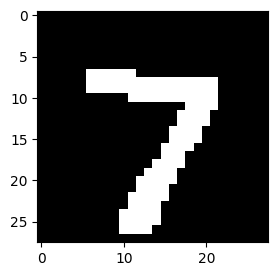

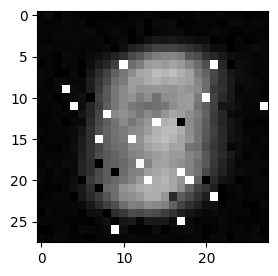

t: 2  loss : 133380.64580894937
t: 3  loss : 140698.3121073807
t: 4  loss : 134866.88859478544
t: 5  loss : 152657.0775834182
t: 6  loss : 117787.11874256156
t: 7  loss : 130668.21195910568
t: 8  loss : 114602.06847726907
t: 9  loss : 121281.24509663074
t: 10  loss : 120588.45710610937
Epoch 11
-------------------------------
t: 11  loss : 114206.77288777962
t: 12  loss : 108251.02373430876
t: 13  loss : 115041.94942393743
t: 14  loss : 104751.80673678234
t: 15  loss : 116236.89845426385
t: 16  loss : 105930.06999080264
t: 17  loss : 111889.5589703923
t: 18  loss : 106969.64674402853
t: 19  loss : 108485.64960633597
t: 20  loss : 107908.58881489788
Epoch 21
-------------------------------
t: 21  loss : 112676.34804202631


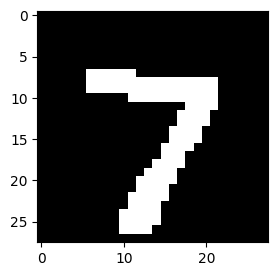

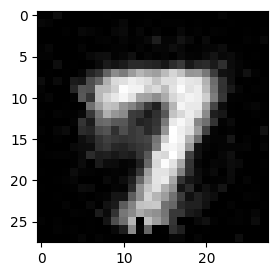

t: 22  loss : 104302.48839233154
t: 23  loss : 105117.47236736503
t: 24  loss : 109454.06841552742
t: 25  loss : 105317.42112702092
t: 26  loss : 106420.47329400538
t: 27  loss : 100115.86768011496
t: 28  loss : 105218.79710207402
t: 29  loss : 100489.20963702032
t: 30  loss : 102961.65770499538
Epoch 31
-------------------------------
t: 31  loss : 104351.64880739726
t: 32  loss : 98956.24004789378
t: 33  loss : 103834.89400359619
t: 34  loss : 100113.83146195734
t: 35  loss : 97370.3722581643
t: 36  loss : 96134.57752684392
t: 37  loss : 103754.81224312748
t: 38  loss : 102571.03869982775
t: 39  loss : 95911.88916793533
t: 40  loss : 100956.1650588979
Epoch 41
-------------------------------
t: 41  loss : 99245.73634467208


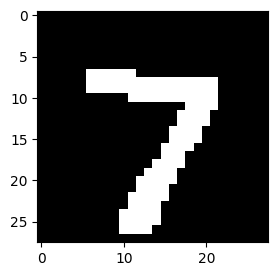

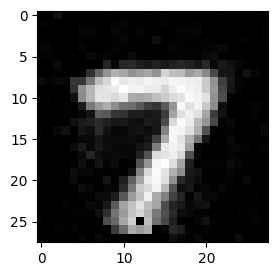

t: 42  loss : 102621.68215768623
t: 43  loss : 96188.26828540064
t: 44  loss : 93420.09926007899
t: 45  loss : 99570.62417548083
t: 46  loss : 101715.38951683149
t: 47  loss : 92527.16582888183
t: 48  loss : 94385.76456347594
t: 49  loss : 96259.172797643
t: 50  loss : 95011.25638219617
Epoch 51
-------------------------------
t: 51  loss : 99199.0977856897
t: 52  loss : 95003.1147222545
t: 53  loss : 100156.7720786304
t: 54  loss : 92385.22270471412
t: 55  loss : 93284.11452450618
t: 56  loss : 87911.60823003777
t: 57  loss : 93626.74878142294
t: 58  loss : 97889.82438935805
t: 59  loss : 90558.77204975956
t: 60  loss : 91190.15172684674
Epoch 61
-------------------------------
t: 61  loss : 94388.24697961961


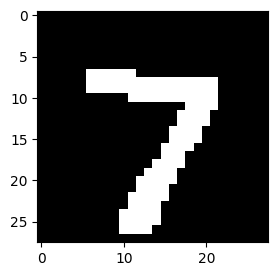

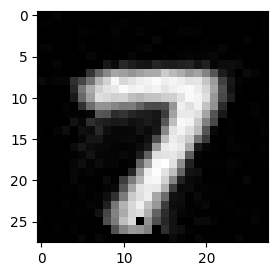

t: 62  loss : 93864.03541040706
t: 63  loss : 90873.60250340574
t: 64  loss : 96584.79693613191
t: 65  loss : 89465.9882126499
t: 66  loss : 94749.46701804183
t: 67  loss : 91752.24523281443
t: 68  loss : 96418.01534868391
t: 69  loss : 99532.48582321024
t: 70  loss : 93085.65155445805
Epoch 71
-------------------------------
t: 71  loss : 90136.04821445644
t: 72  loss : 96005.70495554952
t: 73  loss : 91176.6344668429
t: 74  loss : 94473.77479314328
t: 75  loss : 90001.89817913581
t: 76  loss : 91235.4639396312
t: 77  loss : 95808.98210765723
t: 78  loss : 94414.14163956745
t: 79  loss : 91185.86513261167
t: 80  loss : 84800.39198955431
Epoch 81
-------------------------------
t: 81  loss : 90865.12412037824


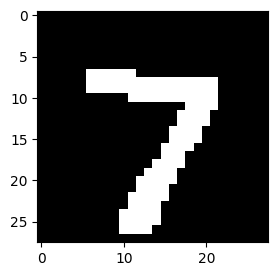

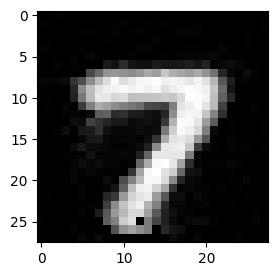

t: 82  loss : 89048.90662050898
t: 83  loss : 89906.80864019538
t: 84  loss : 93323.70712297253
t: 85  loss : 88684.26229054535
t: 86  loss : 87460.84418163312
t: 87  loss : 88175.82111025747
t: 88  loss : 92126.6925675433
t: 89  loss : 87302.1425108769
t: 90  loss : 88144.63957233827
Epoch 91
-------------------------------
t: 91  loss : 88893.73390837408
t: 92  loss : 85888.3578220629
t: 93  loss : 91939.42434758476
t: 94  loss : 91291.19281758874
t: 95  loss : 84918.83936788855
t: 96  loss : 86333.5827388578
t: 97  loss : 85458.4288735855
t: 98  loss : 88938.12257739379
t: 99  loss : 90687.6269665417
t: 100  loss : 87447.82284445304
Epoch 101
-------------------------------
t: 101  loss : 85244.62521736693


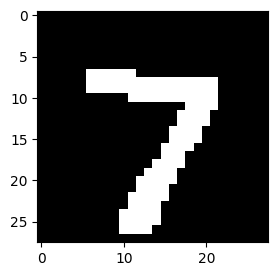

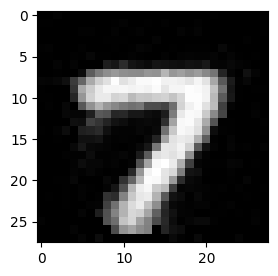

t: 102  loss : 86802.44828495041
t: 103  loss : 88125.17194407298
t: 104  loss : 92441.37131809759
t: 105  loss : 83791.27734972618
t: 106  loss : 82957.1436464888
t: 107  loss : 87776.51709756158
t: 108  loss : 85634.91392032798
t: 109  loss : 83414.92863707303
t: 110  loss : 90730.48462284118
Epoch 111
-------------------------------
t: 111  loss : 87407.04572364294
t: 112  loss : 84661.09547885502
t: 113  loss : 89250.09087656125
t: 114  loss : 86450.4523716496
t: 115  loss : 83054.99970681668
t: 116  loss : 87801.35956554071
t: 117  loss : 87976.54777297452
t: 118  loss : 86627.19255081099
t: 119  loss : 86890.44369968306
t: 120  loss : 82468.13179860712
Epoch 121
-------------------------------
t: 121  loss : 86645.9391919607


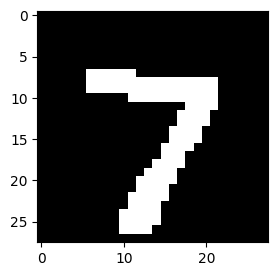

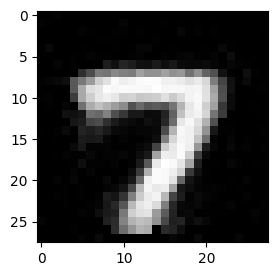

t: 122  loss : 85839.27761284816
t: 123  loss : 87433.38593162432
t: 124  loss : 87895.97018992156
t: 125  loss : 83375.15114040165
t: 126  loss : 86066.943730338
t: 127  loss : 83649.83417846178
t: 128  loss : 83388.33712967258
t: 129  loss : 86943.47061240108
t: 130  loss : 89284.69002068552
Epoch 131
-------------------------------
t: 131  loss : 85650.18824436887
t: 132  loss : 83617.82689014965
t: 133  loss : 84552.40145501394
t: 134  loss : 85349.0635267064
t: 135  loss : 84413.27684997655
t: 136  loss : 82163.17228763735
t: 137  loss : 82927.95813384608
t: 138  loss : 81272.71794604982
t: 139  loss : 78971.75425269545
t: 140  loss : 84235.73449542068
Epoch 141
-------------------------------
t: 141  loss : 85011.39872906025


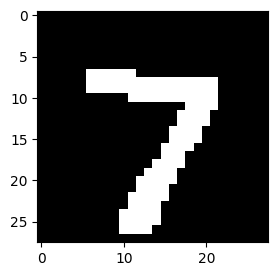

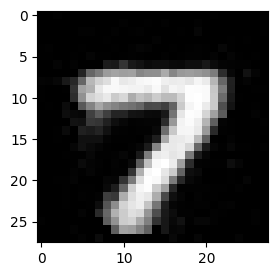

t: 142  loss : 81889.137361332
t: 143  loss : 80870.9313862536
t: 144  loss : 89323.81205294377
t: 145  loss : 86061.03980763594
t: 146  loss : 86802.51235782584
t: 147  loss : 86902.61311443363
t: 148  loss : 84810.32118443718
t: 149  loss : 81102.5799896567
t: 150  loss : 84813.17298225334
Epoch 151
-------------------------------
t: 151  loss : 86132.08178599746
t: 152  loss : 83452.88699626026
t: 153  loss : 78677.62646476143
t: 154  loss : 83590.71426417946
t: 155  loss : 86821.66858062656
t: 156  loss : 87401.96149432474
t: 157  loss : 83304.33811251736
t: 158  loss : 81251.37542141469
t: 159  loss : 78683.12169606186
t: 160  loss : 88425.50040123143
Epoch 161
-------------------------------
t: 161  loss : 83063.82726503891


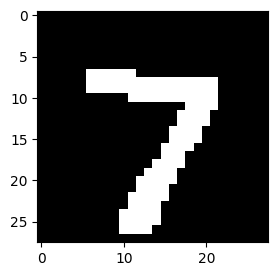

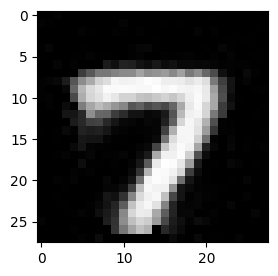

t: 162  loss : 79020.16661928405
t: 163  loss : 82623.05686648111
t: 164  loss : 87617.54136453237
t: 165  loss : 79840.16149461846
t: 166  loss : 82744.60454405003
t: 167  loss : 82227.5013608129
t: 168  loss : 83757.92404699775
t: 169  loss : 83734.7843743228
t: 170  loss : 78778.32606076021
Epoch 171
-------------------------------
t: 171  loss : 82410.7293862973
t: 172  loss : 83034.26264899489
t: 173  loss : 78128.73636223373
t: 174  loss : 79491.5664987133
t: 175  loss : 83206.33160401699
t: 176  loss : 82901.98823224922
t: 177  loss : 84962.22081697299
t: 178  loss : 81102.99553952065
t: 179  loss : 84235.68907125058
t: 180  loss : 81406.52571147244
Epoch 181
-------------------------------
t: 181  loss : 86741.33411728892


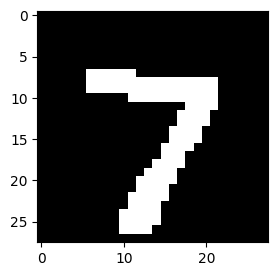

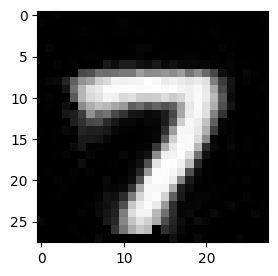

t: 182  loss : 81239.51244380463
t: 183  loss : 81122.15054198208
t: 184  loss : 81188.61312266835
t: 185  loss : 85181.64589990966
t: 186  loss : 82297.5305909048
t: 187  loss : 83968.39371581345
t: 188  loss : 82556.59556567104
t: 189  loss : 82302.32619261082
t: 190  loss : 79806.35439930255
Epoch 191
-------------------------------
t: 191  loss : 76542.4634920574
t: 192  loss : 80884.14316551921
t: 193  loss : 87081.97758139961
t: 194  loss : 81090.77423959223
t: 195  loss : 77813.58955546786
t: 196  loss : 79690.87221265347
t: 197  loss : 81362.29630464666
t: 198  loss : 85376.05038688167
t: 199  loss : 82755.05446107425
t: 200  loss : 81995.29375277154
Epoch 201
-------------------------------
t: 201  loss : 83110.60972894994


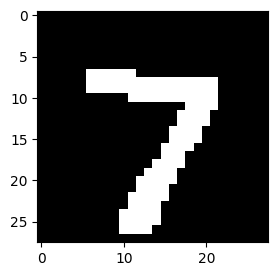

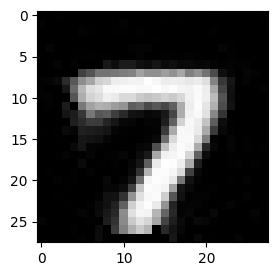

t: 202  loss : 85287.63761288454
t: 203  loss : 79295.33330429015
t: 204  loss : 82137.82957511174
t: 205  loss : 84251.89971713733
t: 206  loss : 82720.74634356167
t: 207  loss : 78756.76323619223
t: 208  loss : 80583.06850763674
t: 209  loss : 80959.64523844501
t: 210  loss : 81940.33904343385
Epoch 211
-------------------------------
t: 211  loss : 82902.54860361567
t: 212  loss : 79821.7229857748
t: 213  loss : 79446.47295117355
t: 214  loss : 83839.60902163794
t: 215  loss : 80777.34433104591
t: 216  loss : 85140.6865993865
t: 217  loss : 79266.43529312624
t: 218  loss : 83626.85818800681
t: 219  loss : 80688.97688089746
t: 220  loss : 83054.65601762147
Epoch 221
-------------------------------
t: 221  loss : 80956.46679501532


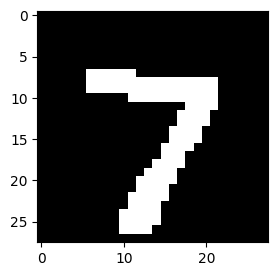

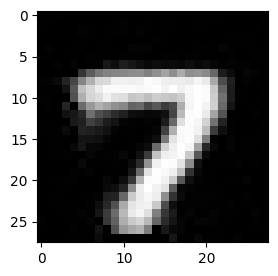

t: 222  loss : 85308.83688268554
t: 223  loss : 82350.31946536446
t: 224  loss : 83114.28348839958
t: 225  loss : 82488.57213548452
t: 226  loss : 81066.25047705551
t: 227  loss : 81939.76006567241
t: 228  loss : 80244.26301726679
t: 229  loss : 79094.18879808173
t: 230  loss : 78538.26057534612
Epoch 231
-------------------------------
t: 231  loss : 78878.18978975168
t: 232  loss : 85436.82926606134
t: 233  loss : 78350.33157757593
t: 234  loss : 76591.37814009833
t: 235  loss : 83863.05955483146
t: 236  loss : 81136.00365549984
t: 237  loss : 80495.34535124546
t: 238  loss : 80193.04625215645
t: 239  loss : 79589.11143407224
t: 240  loss : 79519.22788171686
Epoch 241
-------------------------------
t: 241  loss : 80936.67305590135


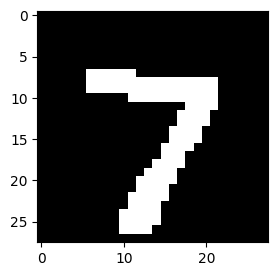

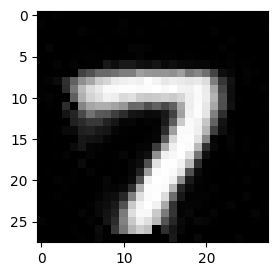

t: 242  loss : 80429.52709868923
t: 243  loss : 77485.66767501115
t: 244  loss : 74852.79862050201
t: 245  loss : 79737.71839186295
t: 246  loss : 85526.69027363212
t: 247  loss : 80579.29221742369
t: 248  loss : 77393.05477604164
t: 249  loss : 78773.59359707212
t: 250  loss : 78008.63964943906
Epoch 251
-------------------------------
t: 251  loss : 83149.67875133829
t: 252  loss : 84644.90054945157
t: 253  loss : 79862.75315782789
t: 254  loss : 80505.59487602332
t: 255  loss : 78472.63710819671
t: 256  loss : 77132.57103159478
t: 257  loss : 77359.36840117008
t: 258  loss : 81933.90641143064
t: 259  loss : 83005.71873010734
t: 260  loss : 80009.01528557739
Epoch 261
-------------------------------
t: 261  loss : 78042.87862832652


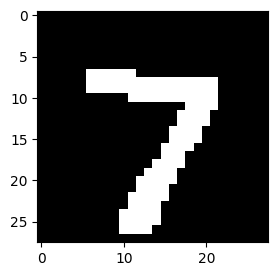

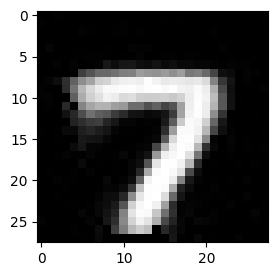

t: 262  loss : 81904.08793485086
t: 263  loss : 81629.85300945316
t: 264  loss : 80068.2965150278
t: 265  loss : 77035.99670243695
t: 266  loss : 79181.40600100887
t: 267  loss : 83542.10386513422
t: 268  loss : 84068.97975714934
t: 269  loss : 76601.79901708766
t: 270  loss : 82692.3864910238
Epoch 271
-------------------------------
t: 271  loss : 83084.07698481872
t: 272  loss : 75568.63860034604
t: 273  loss : 79008.57742695023
t: 274  loss : 82645.49171362574
t: 275  loss : 77183.28331552295
t: 276  loss : 79448.12603108474
t: 277  loss : 80895.55887149245
t: 278  loss : 79195.43597741278
t: 279  loss : 79760.65017769205
t: 280  loss : 78907.58200488375
Epoch 281
-------------------------------
t: 281  loss : 80119.87230439823


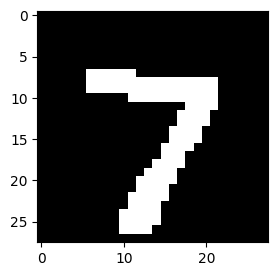

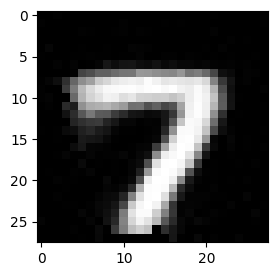

t: 282  loss : 82254.0156993591
t: 283  loss : 79916.83481026169
t: 284  loss : 76441.43494792661
t: 285  loss : 79089.60414668181
t: 286  loss : 81477.15397738236
t: 287  loss : 79397.45922895042
t: 288  loss : 80008.13022768803
t: 289  loss : 76592.67633280238
t: 290  loss : 84185.28193138255
Epoch 291
-------------------------------
t: 291  loss : 82012.08444101068
t: 292  loss : 79898.95193422145
t: 293  loss : 77647.39748866334
t: 294  loss : 78144.77846345908
t: 295  loss : 80495.89581814826
t: 296  loss : 81195.21245102216
t: 297  loss : 77750.37716210981
t: 298  loss : 76610.70636230284
t: 299  loss : 77214.36589208088
t: 300  loss : 80400.78002952605
Epoch 301
-------------------------------
t: 301  loss : 80303.95625312965


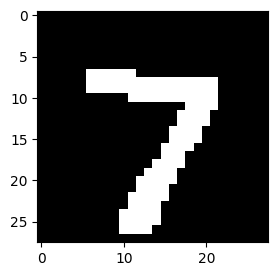

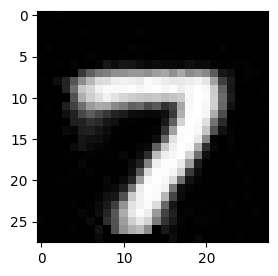

t: 302  loss : 83205.26142452189
t: 303  loss : 81760.71172214329
t: 304  loss : 79761.10037090188
t: 305  loss : 77945.25055591919
t: 306  loss : 76132.86641758584
t: 307  loss : 78457.0516235867
t: 308  loss : 81466.23185132652
t: 309  loss : 77942.89569838648
t: 310  loss : 75740.40323330453
Epoch 311
-------------------------------
t: 311  loss : 82265.93954107257
t: 312  loss : 77345.10891411889
t: 313  loss : 80055.55847000274
t: 314  loss : 79518.4029744278
t: 315  loss : 83426.30703741663
t: 316  loss : 76225.54508364825
t: 317  loss : 75472.00926641007
t: 318  loss : 82605.52753631162
t: 319  loss : 81786.42286620289
t: 320  loss : 79549.30996310242
Epoch 321
-------------------------------
t: 321  loss : 80766.06436418497


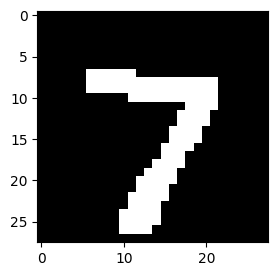

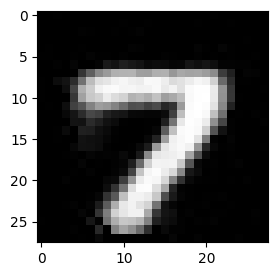

t: 322  loss : 76460.30937460168
t: 323  loss : 78557.4269695921
t: 324  loss : 82071.35066528754
t: 325  loss : 81324.6945595927
t: 326  loss : 79238.02642748335
t: 327  loss : 77621.58471301469
t: 328  loss : 77641.39396904175
t: 329  loss : 73661.0606552789
t: 330  loss : 80345.49906761815
Epoch 331
-------------------------------
t: 331  loss : 76781.59149535773
t: 332  loss : 78594.07980084463
t: 333  loss : 78217.80995661273
t: 334  loss : 78914.68887473656
t: 335  loss : 82419.67510614009
t: 336  loss : 76358.80163922861
t: 337  loss : 79978.54944410892
t: 338  loss : 77763.79892512166
t: 339  loss : 75075.88328604202
t: 340  loss : 82688.82731271793
Epoch 341
-------------------------------
t: 341  loss : 79406.27830444464


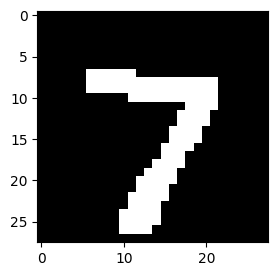

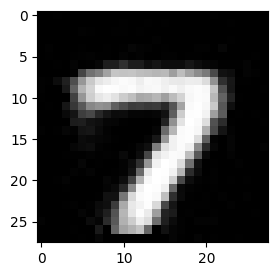

t: 342  loss : 75339.2540539133
t: 343  loss : 79321.93420911558
t: 344  loss : 81448.2235802367
t: 345  loss : 78282.5648369541
t: 346  loss : 80392.26972646895
t: 347  loss : 79104.04296379382
t: 348  loss : 78728.51102350364
t: 349  loss : 79816.36242150028
t: 350  loss : 77833.96375886697
Epoch 351
-------------------------------
t: 351  loss : 77392.21776574008
t: 352  loss : 77474.49457794357
t: 353  loss : 80847.3166531013
t: 354  loss : 79876.07006945538
t: 355  loss : 76115.96301727329
t: 356  loss : 78921.68634887243
t: 357  loss : 81467.38572477533
t: 358  loss : 79503.02493718168
t: 359  loss : 77642.4515342389
t: 360  loss : 75473.37078673494
Epoch 361
-------------------------------
t: 361  loss : 80864.16701373881


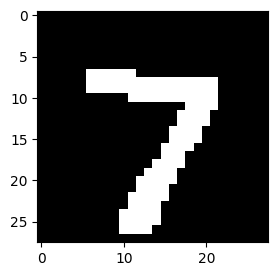

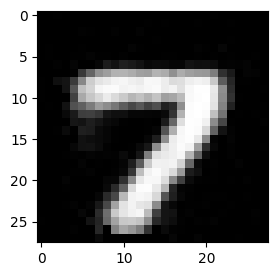

t: 362  loss : 82755.37567616715
t: 363  loss : 78460.0234894182
t: 364  loss : 76585.93675207019
t: 365  loss : 77751.46369071922
t: 366  loss : 77063.582317889
t: 367  loss : 77453.73636580408
t: 368  loss : 78038.69395064533
t: 369  loss : 77167.85477919522
t: 370  loss : 76191.35784748399
Epoch 371
-------------------------------
t: 371  loss : 77566.77594608751
t: 372  loss : 77341.70278326719
t: 373  loss : 76978.4958014444
t: 374  loss : 76672.61740860881
t: 375  loss : 78031.02640271482
t: 376  loss : 76033.65110728955
t: 377  loss : 80040.21301101072
t: 378  loss : 79495.06754659131
t: 379  loss : 81431.16647604071
t: 380  loss : 78365.30849680549
Epoch 381
-------------------------------
t: 381  loss : 75333.43170472828


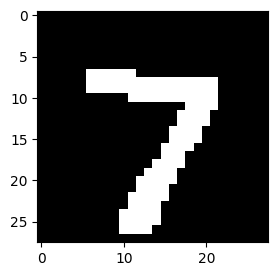

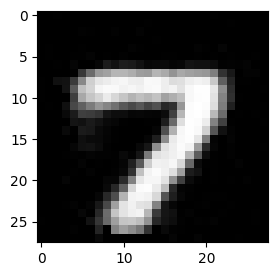

t: 382  loss : 78806.84195445469
t: 383  loss : 81712.55079313213
t: 384  loss : 74368.057632986
t: 385  loss : 75933.34772743752
t: 386  loss : 76262.56279805001
t: 387  loss : 76673.45740032611
t: 388  loss : 79448.01220697914
t: 389  loss : 80158.77165090326
t: 390  loss : 78451.09658438184
Epoch 391
-------------------------------
t: 391  loss : 80765.69183464593
t: 392  loss : 80256.4710686481
t: 393  loss : 77647.32947098212
t: 394  loss : 76883.19302487379
t: 395  loss : 78998.16819082138
t: 396  loss : 78133.1766656992
t: 397  loss : 79899.91729261907
t: 398  loss : 78999.7347682556
t: 399  loss : 74955.60402885394
t: 400  loss : 77607.71019126404
Epoch 401
-------------------------------
t: 401  loss : 73614.54695538821


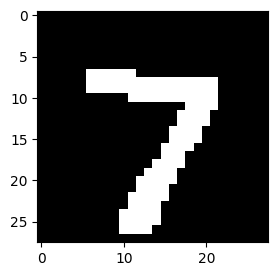

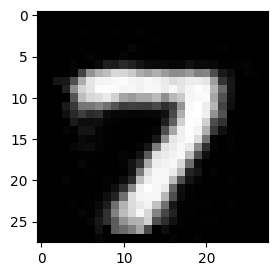

t: 402  loss : 78644.20191898978
t: 403  loss : 80607.88854898239
t: 404  loss : 81510.5264153096
t: 405  loss : 78040.93472496049
t: 406  loss : 76168.41163234483
t: 407  loss : 79404.07570651545
t: 408  loss : 79364.32142137623
t: 409  loss : 76885.54739521003
t: 410  loss : 77262.09131106561
Epoch 411
-------------------------------
t: 411  loss : 79002.9054444725
t: 412  loss : 78206.80531362562
t: 413  loss : 81085.53679528083
t: 414  loss : 83171.08568742336
t: 415  loss : 77828.93110292986
t: 416  loss : 75598.82832433529
t: 417  loss : 79996.65725297642
t: 418  loss : 75778.48610011482
t: 419  loss : 76805.31065487384
t: 420  loss : 79390.33905154797
Epoch 421
-------------------------------
t: 421  loss : 81649.19181660686


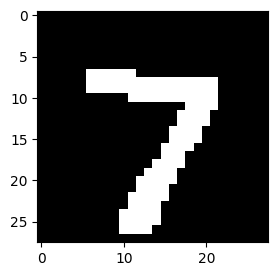

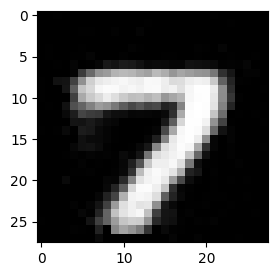

t: 422  loss : 78970.86914064921
t: 423  loss : 80943.88784081406
t: 424  loss : 77112.52617227023
t: 425  loss : 74559.53700020819
t: 426  loss : 76906.4666946542
t: 427  loss : 81752.51725489681
t: 428  loss : 80222.55813352484
t: 429  loss : 73907.52181292964
t: 430  loss : 73148.685956706
Epoch 431
-------------------------------
t: 431  loss : 79797.31124068628
t: 432  loss : 82716.05768774892
t: 433  loss : 77004.07774530858
t: 434  loss : 75783.94531123247
t: 435  loss : 75237.74203495923
t: 436  loss : 78283.48790252226
t: 437  loss : 81737.60177617754
t: 438  loss : 80460.60115358797
t: 439  loss : 74910.46446891254
t: 440  loss : 78414.36408590082
Epoch 441
-------------------------------
t: 441  loss : 77902.22175733707


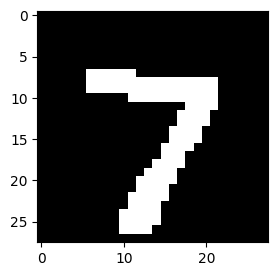

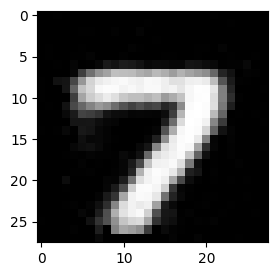

t: 442  loss : 82563.91284460484
t: 443  loss : 80017.54955840234
t: 444  loss : 80099.36125468947
t: 445  loss : 78007.98407096996
t: 446  loss : 73711.19378776039
t: 447  loss : 76190.45836378682
t: 448  loss : 78849.07280772805
t: 449  loss : 77797.45078842476
t: 450  loss : 77185.19623928746
Epoch 451
-------------------------------
t: 451  loss : 76377.85607477864
t: 452  loss : 77214.82200261587
t: 453  loss : 73904.05535662087
t: 454  loss : 78666.74820601272
t: 455  loss : 77127.91953182661
t: 456  loss : 76372.71556815316
t: 457  loss : 75634.93695217295
t: 458  loss : 74325.44620709459
t: 459  loss : 76412.65187008833
t: 460  loss : 78151.13573436145
Epoch 461
-------------------------------
t: 461  loss : 82241.62536131805


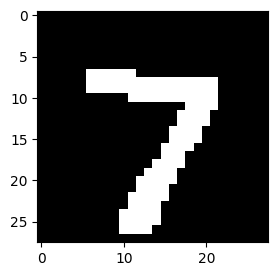

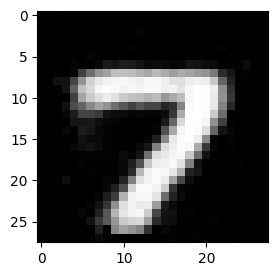

t: 462  loss : 76647.65994116486
t: 463  loss : 76680.28264328295
t: 464  loss : 82866.24530330936
t: 465  loss : 79745.86192928464
t: 466  loss : 75364.70479101785
t: 467  loss : 72232.04680851808
t: 468  loss : 73851.79037982193
t: 469  loss : 78910.27770504472
t: 470  loss : 78021.25666870404
Epoch 471
-------------------------------
t: 471  loss : 78151.59419145688
t: 472  loss : 75793.56069455967
t: 473  loss : 79239.21224135206
t: 474  loss : 78168.17255367947
t: 475  loss : 74927.50046573555
t: 476  loss : 77564.57945099978
t: 477  loss : 76076.01413696716
t: 478  loss : 75352.7934270036
t: 479  loss : 75497.97709547052
t: 480  loss : 79737.06459238015
Epoch 481
-------------------------------
t: 481  loss : 81880.36384463913


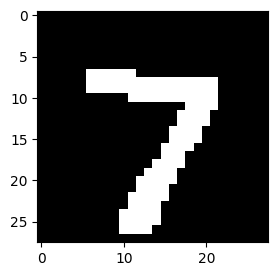

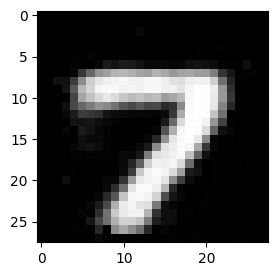

t: 482  loss : 74956.18865470024
t: 483  loss : 72841.03054140208
t: 484  loss : 75151.04595864085
t: 485  loss : 75806.61113983285
t: 486  loss : 78540.69341992498
t: 487  loss : 79111.77710117413
t: 488  loss : 76331.18291896375
t: 489  loss : 79228.34256630462
t: 490  loss : 80869.23860016628
Epoch 491
-------------------------------
t: 491  loss : 76627.37554575414
t: 492  loss : 73168.51018890919
t: 493  loss : 75534.79186263536
t: 494  loss : 75705.01560948255
t: 495  loss : 81961.98449806376
t: 496  loss : 71802.06772306062
t: 497  loss : 74419.35298702963
t: 498  loss : 75451.81463962917
t: 499  loss : 80205.46908553035
t: 500  loss : 75073.83999700323
Epoch 501
-------------------------------
t: 501  loss : 78314.01351355907


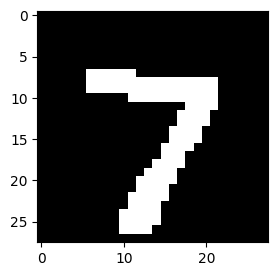

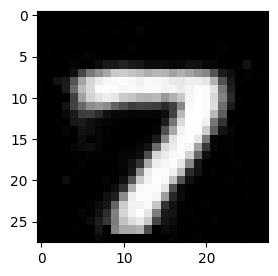

t: 502  loss : 78748.5438121992
t: 503  loss : 78174.24548613535
t: 504  loss : 75186.25747733093
t: 505  loss : 75434.87430889437
t: 506  loss : 74853.91284723199
t: 507  loss : 76348.27079428366
t: 508  loss : 78501.33864864917
t: 509  loss : 76982.91431785369
t: 510  loss : 72989.82016853247
Epoch 511
-------------------------------
t: 511  loss : 75384.35463977825
t: 512  loss : 75930.43698916947
t: 513  loss : 75803.97672515258
t: 514  loss : 78797.95613080614
t: 515  loss : 79833.03245295768
t: 516  loss : 76580.30837359674
t: 517  loss : 81612.89851884851
t: 518  loss : 78624.82540893152
t: 519  loss : 74742.81696218767
t: 520  loss : 74368.94405558123
Epoch 521
-------------------------------
t: 521  loss : 75542.25799216043


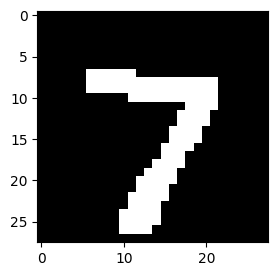

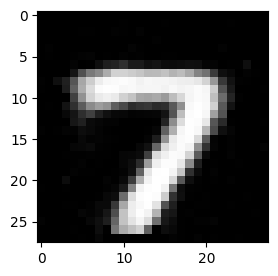

t: 522  loss : 74031.04998280614
t: 523  loss : 73939.33389501061
t: 524  loss : 73808.82996182301
t: 525  loss : 74996.65946505887
t: 526  loss : 76558.70313609357
t: 527  loss : 76256.0039800158
t: 528  loss : 75800.1728679579
t: 529  loss : 79606.59238413107
t: 530  loss : 82265.74538671816
Epoch 531
-------------------------------
t: 531  loss : 79991.5731194342
t: 532  loss : 77500.88438673812
t: 533  loss : 77168.75524540532
t: 534  loss : 80958.81319292155
t: 535  loss : 76054.23072992025
t: 536  loss : 77184.31303890614
t: 537  loss : 78741.8781992089
t: 538  loss : 80344.65045334685
t: 539  loss : 80285.00442179036
t: 540  loss : 81533.92264438487
Epoch 541
-------------------------------
t: 541  loss : 74236.51792696571


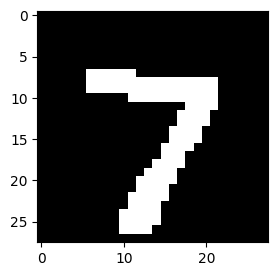

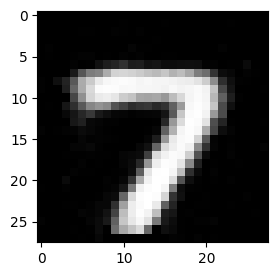

t: 542  loss : 79670.71626211959
t: 543  loss : 80927.46893037508
t: 544  loss : 77904.56517693555
t: 545  loss : 76446.55716076348
t: 546  loss : 75985.7126917749
t: 547  loss : 74810.44545759783
t: 548  loss : 76756.30228177433
t: 549  loss : 75697.75475800957
t: 550  loss : 74628.52259031366
Epoch 551
-------------------------------
t: 551  loss : 79379.9742261462
t: 552  loss : 77113.53886889198
t: 553  loss : 79171.37291093281
t: 554  loss : 82453.70832061207
t: 555  loss : 77049.4685759314
t: 556  loss : 74625.24943425076
t: 557  loss : 76703.38932211985
t: 558  loss : 74923.33433735033
t: 559  loss : 75042.21995865987
t: 560  loss : 76193.54646179223
Epoch 561
-------------------------------
t: 561  loss : 75295.10815453427


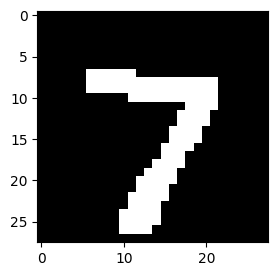

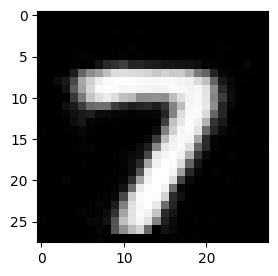

t: 562  loss : 77328.03113241462
t: 563  loss : 81157.76039300786
t: 564  loss : 77214.4535126225
t: 565  loss : 72822.60094800148
t: 566  loss : 75277.4745025083
t: 567  loss : 77445.26329551089
t: 568  loss : 78868.3621437092
t: 569  loss : 80090.41825371273
t: 570  loss : 77403.442382667
Epoch 571
-------------------------------
t: 571  loss : 73279.36210589015
t: 572  loss : 76625.80931912351
t: 573  loss : 78399.69006977636
t: 574  loss : 74919.02264447924
t: 575  loss : 75451.66057295268
t: 576  loss : 80173.90973382366
t: 577  loss : 75525.00456028299
t: 578  loss : 76402.1087400849
t: 579  loss : 75071.82962412164
t: 580  loss : 76022.58354307456
Epoch 581
-------------------------------
t: 581  loss : 77505.08582038076


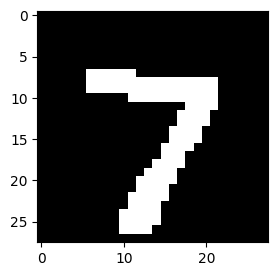

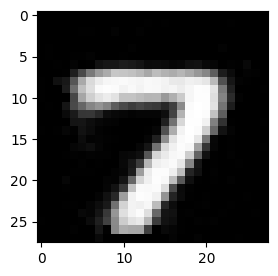

t: 582  loss : 75255.32951475908
t: 583  loss : 71944.11488690061
t: 584  loss : 78068.75656724903
t: 585  loss : 76517.6050475674
t: 586  loss : 76972.63501177117
t: 587  loss : 75091.12185931156
t: 588  loss : 77848.23884570511
t: 589  loss : 76192.82906756065
t: 590  loss : 74719.394799318
Epoch 591
-------------------------------
t: 591  loss : 75009.08707076256
t: 592  loss : 77639.82201706365
t: 593  loss : 79728.10895043766
t: 594  loss : 78273.52337599055
t: 595  loss : 78112.13785051256
t: 596  loss : 77724.16917161465
t: 597  loss : 74754.55197752772
t: 598  loss : 75475.41442939268
t: 599  loss : 74801.49808417598
t: 600  loss : 80648.20546983721


In [52]:
demo_vae = VAE(28*28, 2)
loss = Cross_Entropy_Loss()

epochs = 600
m = train_labels.shape[0]

for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    batch_size = 60
    batch_matrix = shuffle_dataset(m, batch_size)

    l = 0.
    for batch_id in range(batch_size):
        batch_index = batch_matrix[batch_id, :]
        X = train_features[batch_index, :]
        Y = train_features[batch_index, :]

        Z = demo_vae.forward(X)
        #print(Z.shape)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_vae.backward(dL_by_dZ)

        demo_vae.update_weights(learning_rate = 0.35)

    print('t:', t+1, ' loss :', l)

    if (t % 20 == 0):
        X = test_features
        Y = demo_vae.predict(X)
        encode1 = np.resize(X[0], (28, 28))
        decode1 = np.resize(Y[0], (28, 28))

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(encode1, cmap='gray')
        plt.show()

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(decode1, cmap='gray')
        plt.show()